In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz


data_folder = os.getcwd()
train_data_dir = data_folder + "/dataset_mix/training"

from keras import backend as K
K.clear_session()

In [2]:
img_width, img_height = 224, 224
batch_size = 32

# Image Augmentation

In [3]:
data_folder = os.getcwd()
train_data_dir = data_folder + "/dataset_split/training"
validation_data_dir = data_folder + "/dataset_split/validation"

train_datagen2 = ImageDataGenerator(rescale=1/255,
                                  shear_range=0.2,
                                  zoom_range=0.2)
test_datagen2 = ImageDataGenerator(rescale=1/255)

train_generator2 = train_datagen2.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    shuffle=True,
    class_mode='binary')
 
validation_generator2 = test_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False,
    class_mode='binary')

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [4]:
train_generator2.class_indices

{'nonsensitive': 0, 'sensitive': 1}

In [5]:
filenames = validation_generator2.filenames
nb_samples = len(filenames)
anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            factor=0.5, 
                                            patience=5, 
                                            verbose=1, 
                                            min_lr=1e-3)

In [6]:
# Plot the accuracy and loss functions
def plot_graphs(history, string ):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# ModVGGc

In [23]:
K.clear_session()

# define model
pre_trained_modelvggc = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_modelvggc.layers:
    layer._name = layer.name + str("_3")
    layer.trainable = False
    
last_layer = pre_trained_modelvggc.get_layer('block3_pool_3')
last_output = last_layer.output

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(last_output)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

x = AveragePooling2D((2, 2))(pool5)
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)

modelvggc = tf.keras.Model(pre_trained_modelvggc.input, x)
modelvggc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1_3 (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1_3 (Conv2D)     (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2_3 (Conv2D)     (None, 224, 224, 64)      36928     
                                                                 
 block1_pool_3 (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 block2_conv1_3 (Conv2D)     (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2_3 (Conv2D)     (None, 112, 112, 128)     147584    
                                                             

# ModVGGd

In [16]:
K.clear_session()

# define model
pre_trained_modelvggd = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_modelvggd.layers:
    layer._name = layer.name + str("_4")
    layer.trainable = False
    
last_layer = pre_trained_modelvggd.get_layer('block4_pool_4')
last_output = last_layer.output

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(last_output)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

x = AveragePooling2D((2, 2))(pool5)
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)

modelvggd = tf.keras.Model(pre_trained_modelvggd.input, x)
modelvggd.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1_4 (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1_4 (Conv2D)     (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2_4 (Conv2D)     (None, 224, 224, 64)      36928     
                                                                 
 block1_pool_4 (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 block2_conv1_4 (Conv2D)     (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2_4 (Conv2D)     (None, 112, 112, 128)     147584    
                                                             

# ModVGGe

In [7]:
K.clear_session()

# define model
pre_trained_modelvgge = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_modelvgge.layers:
    layer._name = layer.name + str("_5")
    layer.trainable = False
    
last_layer = pre_trained_modelvgge.get_layer('block5_pool_5')
last_output = last_layer.output


x = AveragePooling2D((2, 2))(last_output)
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)

modelvgge = tf.keras.Model(pre_trained_modelvgge.input, x)
modelvgge.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1_5 (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1_5 (Conv2D)     (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2_5 (Conv2D)     (None, 224, 224, 64)      36928     
                                                                 
 block1_pool_5 (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 block2_conv1_5 (Conv2D)     (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2_5 (Conv2D)     (None, 112, 112, 128)     147584    
                                                             

# Orginal VGG

In [8]:
K.clear_session()


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

_input = Input((224,224,3)) 

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(2, activation="softmax")(dense2)

vgg16_model  = Model(inputs=_input, outputs=output)

vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

# Training VGGe

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-3)
modelvgge.compile(optimizer=opt,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = modelvgge.fit(train_generator2, 
                          steps_per_epoch=train_generator2.samples // batch_size, 
                          epochs = 10,
                          validation_data=validation_generator2, 
                          validation_steps=validation_generator2.samples // batch_size,
                          batch_size = batch_size, 
                          verbose = 1,
                          callbacks=[anne])

Epoch 1/10
30/30 [==============================] - 108s 4s/step - loss: 1.1027 - accuracy: 0.8531 - val_loss: 0.1107 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 105s 4s/step - loss: 0.0915 - accuracy: 0.9656 - val_loss: 0.0504 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 102s 3s/step - loss: 0.0972 - accuracy: 0.9698 - val_loss: 0.2132 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 103s 3s/step - loss: 0.1050 - accuracy: 0.9698 - val_loss: 0.0660 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 104s 3s/step - loss: 0.0325 - accuracy: 0.9885 - val_loss: 0.1324 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 103s 3s/step - loss: 0.0279 - accuracy: 0.9885 - val_loss: 0.1113 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 103s 3s/step - loss: 0.0

8/8 [==============================] - 19s 2s/step
Confusion Matrix
[[116   4]
 [  3 117]]


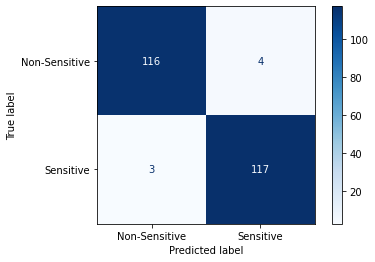

Classification Report
               precision    recall  f1-score   support

Non-Sensitive       0.97      0.97      0.97       120
    Sensitive       0.97      0.97      0.97       120

     accuracy                           0.97       240
    macro avg       0.97      0.97      0.97       240
 weighted avg       0.97      0.97      0.97       240

True Negative             116
False Negative            3
True Positive             117
False Positive            4
recall                    0.975
Specificity               0.9666666666666667
Precision                 0.9669421487603306
Negative predictive value 0.9747899159663865
false positive rate       0.03333333333333333
False negative rate       0.025
False discovery rate      0.03305785123966942
accuracy                  0.9708333333333333
8/8 - 18s - loss: 0.1238 - accuracy: 0.9708 - 18s/epoch - 2s/step
Test Loss: 0.12383487820625305 
Test Accuracy: 0.9708333611488342


In [10]:
Y_pred = modelvgge.predict(validation_generator2, nb_samples // batch_size)
y_pred = Y_pred > 0.5
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator2.classes, y_pred)
print(cm)
target_names = ['Non-Sensitive', 'Sensitive' ]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Negative            ', TN)
print('False Negative           ', FN)
print('True Positive            ', TP)
print('False Positive           ', FP)

print('recall                   ', TPR)
print('Specificity              ', TNR)
print('Precision                ', PPV)
print('Negative predictive value', NPV)
print('false positive rate      ', FPR)
print('False negative rate      ', FNR)
print('False discovery rate     ', FDR)
print('accuracy                 ', ACC)

val_loss, val_mae = modelvgge.evaluate(validation_generator2, verbose=2)
print('Test Loss:', val_loss, '\nTest Accuracy:', val_mae)

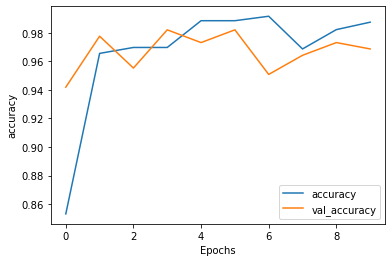

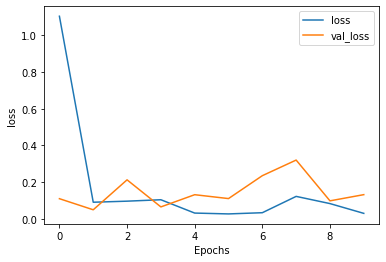

In [11]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

modelvgge.save('model2/Fixmodvgge.h5')

    # convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

    # save to json:  
hist_json_file = "model_2/Fixmodvgge.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
K.clear_session()

# Training VGGd

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-3)
modelvggd.compile(optimizer=opt,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = modelvggd.fit(train_generator2, 
                          steps_per_epoch=train_generator2.samples // batch_size, 
                          epochs = 10,
                          validation_data=validation_generator2, 
                          validation_steps=validation_generator2.samples // batch_size,
                          batch_size = batch_size, 
                          verbose = 1,
                          callbacks=[anne])

Epoch 1/10
30/30 [==============================] - 126s 4s/step - loss: 3.5634 - accuracy: 0.7208 - val_loss: 0.6046 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 126s 4s/step - loss: 0.1967 - accuracy: 0.9271 - val_loss: 0.1313 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 126s 4s/step - loss: 0.0946 - accuracy: 0.9781 - val_loss: 0.0875 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 125s 4s/step - loss: 0.0366 - accuracy: 0.9896 - val_loss: 0.0545 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 126s 4s/step - loss: 0.0473 - accuracy: 0.9885 - val_loss: 0.0580 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 126s 4s/step - loss: 0.0359 - accuracy: 0.9896 - val_loss: 0.1697 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 126s 4s/step - loss: 0.1

8/8 [==============================] - 20s 2s/step
Confusion Matrix
[[116   4]
 [  1 119]]


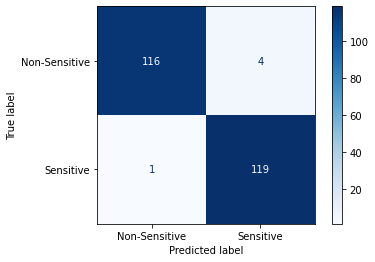

Classification Report
               precision    recall  f1-score   support

Non-Sensitive       0.99      0.97      0.98       120
    Sensitive       0.97      0.99      0.98       120

     accuracy                           0.98       240
    macro avg       0.98      0.98      0.98       240
 weighted avg       0.98      0.98      0.98       240

True Negative             116
False Negative            1
True Positive             119
False Positive            4
recall                    0.9916666666666667
Specificity               0.9666666666666667
Precision                 0.967479674796748
Negative predictive value 0.9914529914529915
false positive rate       0.03333333333333333
False negative rate       0.008333333333333333
False discovery rate      0.032520325203252036
accuracy                  0.9791666666666666
8/8 - 20s - loss: 0.1234 - accuracy: 0.9792 - 20s/epoch - 3s/step
Test Loss: 0.1233576163649559 
Test Accuracy: 0.9791666865348816


In [18]:
Y_pred = modelvggd.predict(validation_generator2, nb_samples // batch_size)
y_pred = Y_pred > 0.5
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator2.classes, y_pred)
print(cm)
target_names = ['Non-Sensitive', 'Sensitive' ]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Negative            ', TN)
print('False Negative           ', FN)
print('True Positive            ', TP)
print('False Positive           ', FP)

print('recall                   ', TPR)
print('Specificity              ', TNR)
print('Precision                ', PPV)
print('Negative predictive value', NPV)
print('false positive rate      ', FPR)
print('False negative rate      ', FNR)
print('False discovery rate     ', FDR)
print('accuracy                 ', ACC)

val_loss, val_mae = modelvggd.evaluate(validation_generator2, verbose=2)
print('Test Loss:', val_loss, '\nTest Accuracy:', val_mae)

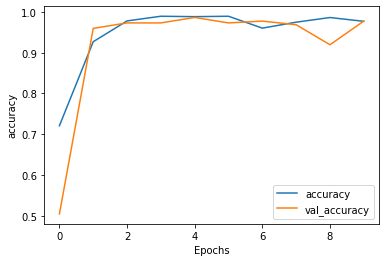

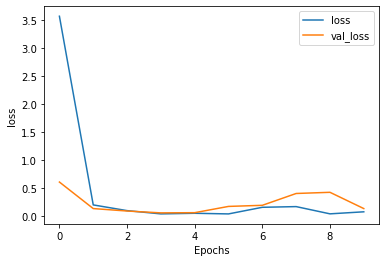

In [19]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

modelvggd.save('model2/Fixmodvggd.h5')

    # convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

    # save to json:  
hist_json_file = "model_2/Fixmodvggd.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
K.clear_session()

# Training VGGc

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-3)
modelvggc.compile(optimizer=opt,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = modelvggc.fit(train_generator2, 
                          steps_per_epoch=train_generator2.samples // batch_size, 
                          epochs = 10,
                          validation_data=validation_generator2, 
                          validation_steps=validation_generator2.samples // batch_size,
                          batch_size = batch_size, 
                          verbose = 1,
                          callbacks=[anne])

Epoch 1/10
30/30 [==============================] - 183s 6s/step - loss: 175.3922 - accuracy: 0.5177 - val_loss: 0.7072 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 182s 6s/step - loss: 0.6534 - accuracy: 0.5885 - val_loss: 4.8439 - val_accuracy: 0.5089 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 181s 6s/step - loss: 0.8591 - accuracy: 0.5385 - val_loss: 0.6794 - val_accuracy: 0.5402 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 181s 6s/step - loss: 0.6922 - accuracy: 0.5562 - val_loss: 0.6565 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 186s 6s/step - loss: 0.6277 - accuracy: 0.6771 - val_loss: 0.4824 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 183s 6s/step - loss: 0.4835 - accuracy: 0.7958 - val_loss: 0.4314 - val_accuracy: 0.8304 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 183s 6s/step - loss: 0

8/8 [==============================] - 20s 2s/step
Confusion Matrix
[[114   6]
 [ 16 104]]


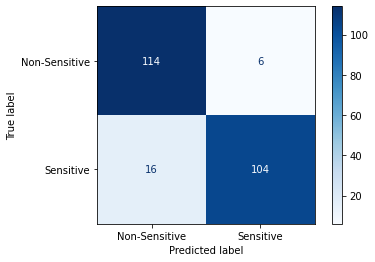

Classification Report
               precision    recall  f1-score   support

Non-Sensitive       0.88      0.95      0.91       120
    Sensitive       0.95      0.87      0.90       120

     accuracy                           0.91       240
    macro avg       0.91      0.91      0.91       240
 weighted avg       0.91      0.91      0.91       240

True Negative             114
False Negative            16
True Positive             104
False Positive            6
recall                    0.8666666666666667
Specificity               0.95
Precision                 0.9454545454545454
Negative predictive value 0.8769230769230769
false positive rate       0.05
False negative rate       0.13333333333333333
False discovery rate      0.05454545454545454
accuracy                  0.9083333333333333
8/8 - 20s - loss: 0.3123 - accuracy: 0.9083 - 20s/epoch - 2s/step
Test Loss: 0.31231385469436646 
Test Accuracy: 0.9083333611488342


In [25]:
Y_pred = modelvggc.predict(validation_generator2, nb_samples // batch_size)
y_pred = Y_pred > 0.5
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator2.classes, y_pred)
print(cm)
target_names = ['Non-Sensitive', 'Sensitive' ]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Negative            ', TN)
print('False Negative           ', FN)
print('True Positive            ', TP)
print('False Positive           ', FP)

print('recall                   ', TPR)
print('Specificity              ', TNR)
print('Precision                ', PPV)
print('Negative predictive value', NPV)
print('false positive rate      ', FPR)
print('False negative rate      ', FNR)
print('False discovery rate     ', FDR)
print('accuracy                 ', ACC)

val_loss, val_mae = modelvggc.evaluate(validation_generator2, verbose=2)
print('Test Loss:', val_loss, '\nTest Accuracy:', val_mae)

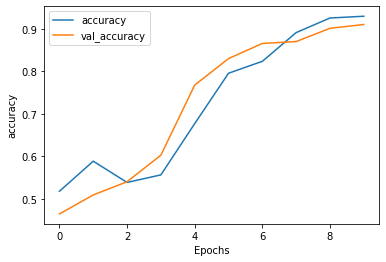

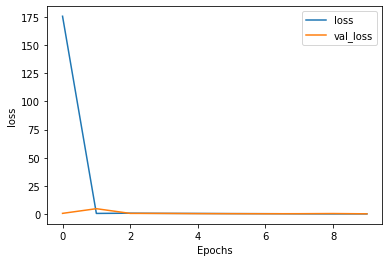

In [26]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

modelvggc.save('model2/Fixmodvggc.h5')

    # convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

    # save to json:  
hist_json_file = "model_2/Fixmodvggc.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
K.clear_session()

# Training Original VGG

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-3)
vgg16_model.compile(optimizer=opt,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = vgg16_model.fit(train_generator2, 
                          steps_per_epoch=train_generator2.samples // batch_size, 
                          epochs = 10,
                          validation_data=validation_generator2, 
                          validation_steps=validation_generator2.samples // batch_size,
                          batch_size = batch_size, 
                          verbose = 1,
                          callbacks=[anne])

Epoch 1/10
30/30 [==============================] - 387s 13s/step - loss: 30.1178 - accuracy: 0.4865 - val_loss: 0.6934 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 386s 13s/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 388s 13s/step - loss: 0.6934 - accuracy: 0.4938 - val_loss: 0.6926 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 385s 13s/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 383s 13s/step - loss: 0.6932 - accuracy: 0.4667 - val_loss: 0.6930 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 383s 13s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 379s 13s/step - l

8/8 [==============================] - 20s 2s/step
Confusion Matrix
[[  0 120]
 [  0 120]]


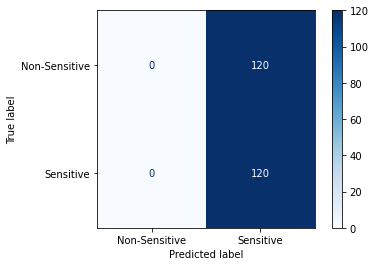

Classification Report
               precision    recall  f1-score   support

Non-Sensitive       0.00      0.00      0.00       120
    Sensitive       0.50      1.00      0.67       120

     accuracy                           0.50       240
    macro avg       0.25      0.50      0.33       240
 weighted avg       0.25      0.50      0.33       240

True Negative             0
False Negative            0
True Positive             120
False Positive            120
recall                    1.0
Specificity               0.0
Precision                 0.5
Negative predictive value nan
false positive rate       1.0
False negative rate       0.0
False discovery rate      0.5
accuracy                  0.5


C:\Users\D12\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\D12\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\D12\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-21-707de29afb10>:27: RuntimeWarning: invalid v

8/8 - 20s - loss: 0.6931 - accuracy: 0.5000 - 20s/epoch - 2s/step
Test Loss: 0.6931473612785339 
Test Accuracy: 0.5


In [21]:
Y_pred = vgg16_model.predict(validation_generator2, nb_samples // batch_size)
y_pred = Y_pred > 0.5
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator2.classes, y_pred)
print(cm)
target_names = ['Non-Sensitive', 'Sensitive' ]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Negative            ', TN)
print('False Negative           ', FN)
print('True Positive            ', TP)
print('False Positive           ', FP)

print('recall                   ', TPR)
print('Specificity              ', TNR)
print('Precision                ', PPV)
print('Negative predictive value', NPV)
print('false positive rate      ', FPR)
print('False negative rate      ', FNR)
print('False discovery rate     ', FDR)
print('accuracy                 ', ACC)

val_loss, val_mae = vgg16_model.evaluate(validation_generator2, verbose=2)
print('Test Loss:', val_loss, '\nTest Accuracy:', val_mae)

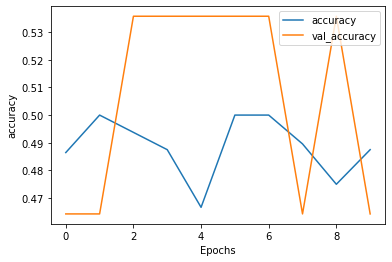

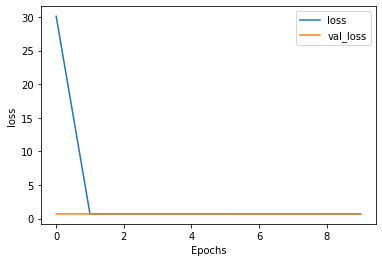

In [22]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

vgg16_model.save('model2/Fixvggori.h5')

    # convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

    # save to json:  
hist_json_file = "model_2/Fixvggori.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
K.clear_session()

# VGGoriImagenet

In [12]:
K.clear_session()

# define model
pre_trained_vgg = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=True, weights="imagenet")
for layer in pre_trained_vgg.layers:
    layer._name = layer.name + str("_6")
    layer.trainable = False
    
last_layer = pre_trained_vgg.get_layer('fc2_6')
last_output = last_layer.output
last_output = Dense(2, activation="softmax")(last_output)

vgg = tf.keras.Model(pre_trained_vgg.input, last_output)
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1_6 (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1_6 (Conv2D)     (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2_6 (Conv2D)     (None, 224, 224, 64)      36928     
                                                                 
 block1_pool_6 (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 block2_conv1_6 (Conv2D)     (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2_6 (Conv2D)     (None, 112, 112, 128)     147584    
                                                             

# VGGoriImagenet

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-3)
vgg.compile(optimizer=opt,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = vgg.fit(train_generator2, 
                          steps_per_epoch=train_generator2.samples // batch_size, 
                          epochs = 10,
                          validation_data=validation_generator2, 
                          validation_steps=validation_generator2.samples // batch_size,
                          batch_size = batch_size, 
                          verbose = 1,
                          callbacks=[anne])

Epoch 1/10
30/30 [==============================] - 94s 3s/step - loss: 0.4421 - accuracy: 0.7802 - val_loss: 0.1569 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 93s 3s/step - loss: 0.1641 - accuracy: 0.9365 - val_loss: 0.1493 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 92s 3s/step - loss: 0.1601 - accuracy: 0.9448 - val_loss: 0.1358 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 93s 3s/step - loss: 0.1539 - accuracy: 0.9458 - val_loss: 0.1172 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 92s 3s/step - loss: 0.1225 - accuracy: 0.9615 - val_loss: 0.1290 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 95s 3s/step - loss: 0.1438 - accuracy: 0.9490 - val_loss: 0.1356 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 100s 3s/step - loss: 0.1292 - 

8/8 [==============================] - 20s 2s/step
Confusion Matrix
[[120   0]
 [ 21  99]]


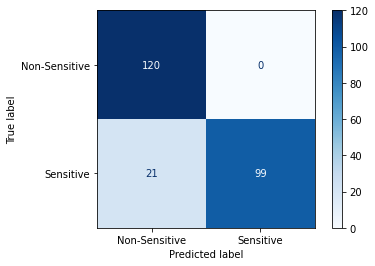

Classification Report
               precision    recall  f1-score   support

Non-Sensitive       0.85      1.00      0.92       120
    Sensitive       1.00      0.82      0.90       120

     accuracy                           0.91       240
    macro avg       0.93      0.91      0.91       240
 weighted avg       0.93      0.91      0.91       240

True Negative             120
False Negative            21
True Positive             99
False Positive            0
recall                    0.825
Specificity               1.0
Precision                 1.0
Negative predictive value 0.851063829787234
false positive rate       0.0
False negative rate       0.175
False discovery rate      0.0
accuracy                  0.9125
8/8 - 20s - loss: 0.2679 - accuracy: 0.9125 - 20s/epoch - 2s/step
Test Loss: 0.26788216829299927 
Test Accuracy: 0.9125000238418579


In [14]:
Y_pred = vgg.predict(validation_generator2, nb_samples // batch_size)
y_pred = Y_pred > 0.5
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator2.classes, y_pred)
print(cm)
target_names = ['Non-Sensitive', 'Sensitive' ]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Negative            ', TN)
print('False Negative           ', FN)
print('True Positive            ', TP)
print('False Positive           ', FP)

print('recall                   ', TPR)
print('Specificity              ', TNR)
print('Precision                ', PPV)
print('Negative predictive value', NPV)
print('false positive rate      ', FPR)
print('False negative rate      ', FNR)
print('False discovery rate     ', FDR)
print('accuracy                 ', ACC)

val_loss, val_mae = vgg.evaluate(validation_generator2, verbose=2)
print('Test Loss:', val_loss, '\nTest Accuracy:', val_mae)

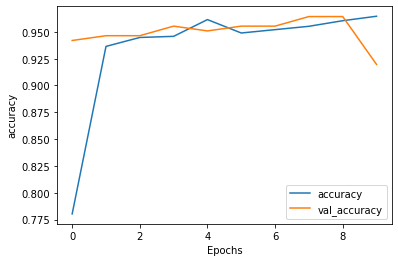

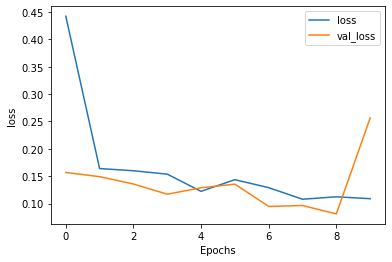

In [15]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

vgg.save('model2/Fixvgg.h5')

    # convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

    # save to json:  
hist_json_file = "model_2/Fixvgg.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
K.clear_session()

In [27]:
K.clear_session()

# define model
pre_trained_vggs = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=True, weights="imagenet")
    
vggs = tf.keras.Model(pre_trained_vggs.input, pre_trained_vggs.output)
vggs.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-3)
vggs.compile(optimizer=opt,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = vggs.fit(train_generator2, 
                          steps_per_epoch=train_generator2.samples // batch_size, 
                          epochs = 10,
                          validation_data=validation_generator2, 
                          validation_steps=validation_generator2.samples // batch_size,
                          batch_size = batch_size, 
                          verbose = 1,
                          callbacks=[anne])

Epoch 1/10
30/30 [==============================] - 403s 13s/step - loss: 6.2435 - accuracy: 0.4844 - val_loss: 0.6788 - val_accuracy: 0.5491 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 387s 13s/step - loss: 0.9244 - accuracy: 0.4792 - val_loss: 0.7297 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 385s 13s/step - loss: 0.6918 - accuracy: 0.5562 - val_loss: 0.6562 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 383s 13s/step - loss: 0.6562 - accuracy: 0.6073 - val_loss: 0.6241 - val_accuracy: 0.6652 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 383s 13s/step - loss: 0.6891 - accuracy: 0.5792 - val_loss: 0.5999 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 385s 13s/step - loss: 0.6162 - accuracy: 0.6625 - val_loss: 0.6389 - val_accuracy: 0.6652 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 384s 13s/step - lo

8/8 [==============================] - 20s 2s/step
Confusion Matrix
[[115   5]
 [ 13 107]]


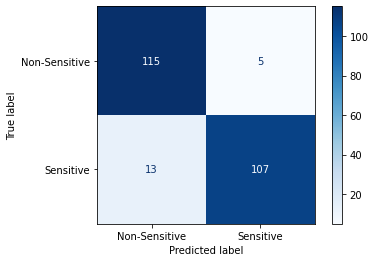

Classification Report
               precision    recall  f1-score   support

Non-Sensitive       0.90      0.96      0.93       120
    Sensitive       0.96      0.89      0.92       120

     accuracy                           0.93       240
    macro avg       0.93      0.93      0.92       240
 weighted avg       0.93      0.93      0.92       240

True Negative             115
False Negative            13
True Positive             107
False Positive            5
recall                    0.8916666666666667
Specificity               0.9583333333333334
Precision                 0.9553571428571429
Negative predictive value 0.8984375
false positive rate       0.041666666666666664
False negative rate       0.10833333333333334
False discovery rate      0.044642857142857144
accuracy                  0.925
8/8 - 20s - loss: 0.2174 - accuracy: 0.9250 - 20s/epoch - 2s/step
Test Loss: 0.21739651262760162 
Test Accuracy: 0.925000011920929


In [30]:
Y_pred = vggs.predict(validation_generator2, nb_samples // batch_size)
y_pred = Y_pred > 0.5
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator2.classes, y_pred)
print(cm)
target_names = ['Non-Sensitive', 'Sensitive' ]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Negative            ', TN)
print('False Negative           ', FN)
print('True Positive            ', TP)
print('False Positive           ', FP)

print('recall                   ', TPR)
print('Specificity              ', TNR)
print('Precision                ', PPV)
print('Negative predictive value', NPV)
print('false positive rate      ', FPR)
print('False negative rate      ', FNR)
print('False discovery rate     ', FDR)
print('accuracy                 ', ACC)

val_loss, val_mae = vggs.evaluate(validation_generator2, verbose=2)
print('Test Loss:', val_loss, '\nTest Accuracy:', val_mae)

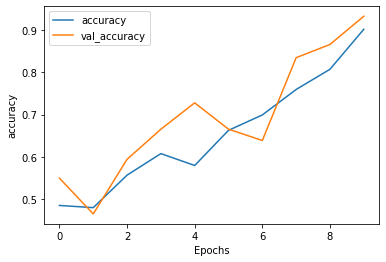

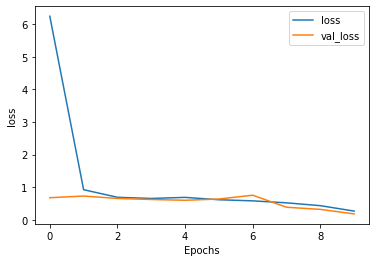

In [32]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

vggs.save('model2/Fixvggs.h5')

    # convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

    # save to json:  
hist_json_file = "model_2/Fixvggs.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
K.clear_session()

In [38]:
K.clear_session()

# define model
pre_trained_resnet = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=True, weights="imagenet")
    
resnet = tf.keras.Model(pre_trained_resnet.input, pre_trained_resnet.output)
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [39]:
K.clear_session()

# define model
pre_trained_resnet2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3), include_top=True, weights="imagenet")
    
resnet2 = tf.keras.Model(pre_trained_resnet2.input, pre_trained_resnet2.output)
resnet2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

In [40]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-3)
resnet.compile(optimizer=opt,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = resnet.fit(train_generator2, 
                          steps_per_epoch=train_generator2.samples // batch_size, 
                          epochs = 10,
                          validation_data=validation_generator2, 
                          validation_steps=validation_generator2.samples // batch_size,
                          batch_size = batch_size, 
                          verbose = 1,
                          callbacks=[anne])

Epoch 1/10
30/30 [==============================] - 244s 8s/step - loss: 0.9444 - accuracy: 0.8562 - val_loss: 69241.1484 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 238s 8s/step - loss: 0.3500 - accuracy: 0.9208 - val_loss: 29699.0918 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 237s 8s/step - loss: 0.2209 - accuracy: 0.9365 - val_loss: 2.3166 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 238s 8s/step - loss: 0.0832 - accuracy: 0.9688 - val_loss: 7.7121 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 235s 8s/step - loss: 0.0922 - accuracy: 0.9719 - val_loss: 1.1092 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 236s 8s/step - loss: 0.0497 - accuracy: 0.9802 - val_loss: 1.2276 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 236s 8s/step - l

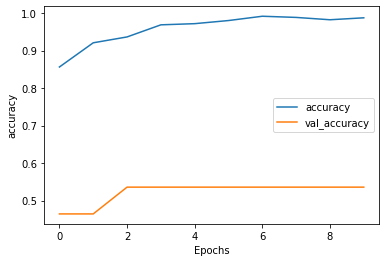

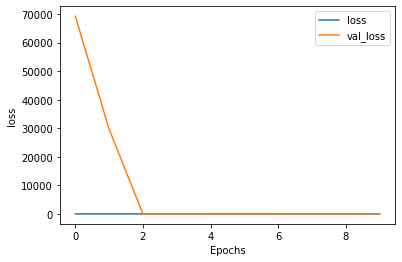

In [41]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

resnet.save('model2/resnet.h5')

    # convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

    # save to json:  
hist_json_file = "model_2/resnet.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
K.clear_session()

8/8 [==============================] - 12s 1s/step
Confusion Matrix
[[120   0]
 [120   0]]


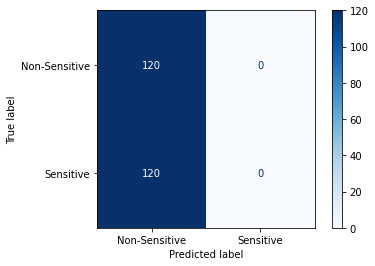

Classification Report
               precision    recall  f1-score   support

Non-Sensitive       0.50      1.00      0.67       120
    Sensitive       0.00      0.00      0.00       120

     accuracy                           0.50       240
    macro avg       0.25      0.50      0.33       240
 weighted avg       0.25      0.50      0.33       240

True Negative             120
False Negative            120
True Positive             0
False Positive            0
recall                    0.0
Specificity               1.0
Precision                 nan
Negative predictive value 0.5
false positive rate       0.0
False negative rate       1.0
False discovery rate      nan
accuracy                  0.5


C:\Users\D12\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\D12\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\D12\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-42-94c62bd20565>:25: RuntimeWarning: invalid v

8/8 - 11s - loss: 1.5879 - accuracy: 0.5000 - 11s/epoch - 1s/step
Test Loss: 1.5879210233688354 
Test Accuracy: 0.5


In [42]:
Y_pred = resnet.predict(validation_generator2, nb_samples // batch_size)
y_pred = Y_pred > 0.5
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator2.classes, y_pred)
print(cm)
target_names = ['Non-Sensitive', 'Sensitive' ]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Negative            ', TN)
print('False Negative           ', FN)
print('True Positive            ', TP)
print('False Positive           ', FP)

print('recall                   ', TPR)
print('Specificity              ', TNR)
print('Precision                ', PPV)
print('Negative predictive value', NPV)
print('false positive rate      ', FPR)
print('False negative rate      ', FNR)
print('False discovery rate     ', FDR)
print('accuracy                 ', ACC)

val_loss, val_mae = resnet.evaluate(validation_generator2, verbose=2)
print('Test Loss:', val_loss, '\nTest Accuracy:', val_mae)

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-3)
resnet2.compile(optimizer=opt,loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = resnet2.fit(train_generator2, 
                          steps_per_epoch=train_generator2.samples // batch_size, 
                          epochs = 10,
                          validation_data=validation_generator2, 
                          validation_steps=validation_generator2.samples // batch_size,
                          batch_size = batch_size, 
                          verbose = 1,
                          callbacks=[anne])

Epoch 1/10
30/30 [==============================] - 200s 7s/step - loss: 0.9800 - accuracy: 0.8562 - val_loss: 8.9324 - val_accuracy: 0.5089 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 195s 7s/step - loss: 0.1968 - accuracy: 0.9323 - val_loss: 1.3428 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 195s 7s/step - loss: 0.0927 - accuracy: 0.9740 - val_loss: 0.8587 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 195s 7s/step - loss: 0.0622 - accuracy: 0.9781 - val_loss: 1.4150 - val_accuracy: 0.8080 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 195s 6s/step - loss: 0.0795 - accuracy: 0.9750 - val_loss: 7.0252 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 196s 7s/step - loss: 0.0641 - accuracy: 0.9792 - val_loss: 0.2124 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 195s 7s/step - loss: 0.0

8/8 [==============================] - 9s 1s/step
Confusion Matrix
[[120   0]
 [ 77  43]]


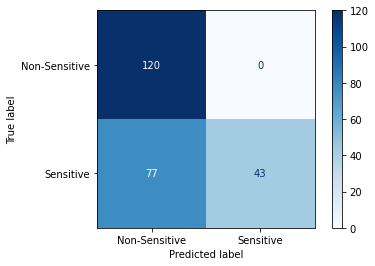

Classification Report
               precision    recall  f1-score   support

Non-Sensitive       0.61      1.00      0.76       120
    Sensitive       1.00      0.36      0.53       120

     accuracy                           0.68       240
    macro avg       0.80      0.68      0.64       240
 weighted avg       0.80      0.68      0.64       240

True Negative             120
False Negative            77
True Positive             43
False Positive            0
recall                    0.35833333333333334
Specificity               1.0
Precision                 1.0
Negative predictive value 0.6091370558375635
false positive rate       0.0
False negative rate       0.6416666666666667
False discovery rate      0.0
accuracy                  0.6791666666666667
8/8 - 9s - loss: 2.1842 - accuracy: 0.6792 - 9s/epoch - 1s/step
Test Loss: 2.1841511726379395 
Test Accuracy: 0.6791666746139526


In [44]:
Y_pred = resnet2.predict(validation_generator2, nb_samples // batch_size)
y_pred = Y_pred > 0.5
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator2.classes, y_pred)
print(cm)
target_names = ['Non-Sensitive', 'Sensitive' ]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('True Negative            ', TN)
print('False Negative           ', FN)
print('True Positive            ', TP)
print('False Positive           ', FP)

print('recall                   ', TPR)
print('Specificity              ', TNR)
print('Precision                ', PPV)
print('Negative predictive value', NPV)
print('false positive rate      ', FPR)
print('False negative rate      ', FNR)
print('False discovery rate     ', FDR)
print('accuracy                 ', ACC)

val_loss, val_mae = resnet2.evaluate(validation_generator2, verbose=2)
print('Test Loss:', val_loss, '\nTest Accuracy:', val_mae)

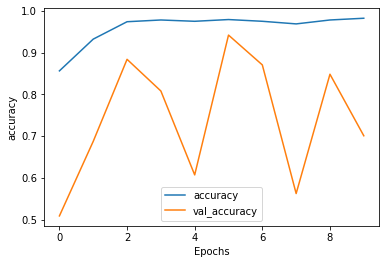

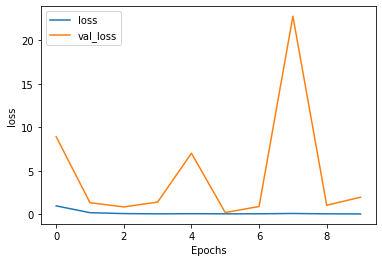

In [45]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

resnet2.save('model2/resnet2.h5')

    # convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

    # save to json:  
hist_json_file = "model_2/resnet2.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
K.clear_session()